Task 2: Develop Time Series Forecasting Models for All Datasets

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import warnings
warnings.filterwarnings("ignore")

tsla_data = pd.read_csv('../data/TSLA_data.csv', index_col='Date', parse_dates=True)
spy_data = pd.read_csv('../data/SPY_data.csv', index_col='Date', parse_dates=True)
bnd_data = pd.read_csv('../data/BND_data.csv', index_col='Date', parse_dates=True)


In [32]:
def preprocess_data(df):
    df = df[['Close']].copy()
    df.dropna(inplace=True)
    return df

tsla_data = preprocess_data(tsla_data)
spy_data = preprocess_data(spy_data)
bnd_data = preprocess_data(bnd_data)

In [33]:
def evaluate_forecast(actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    return mae, rmse, mape


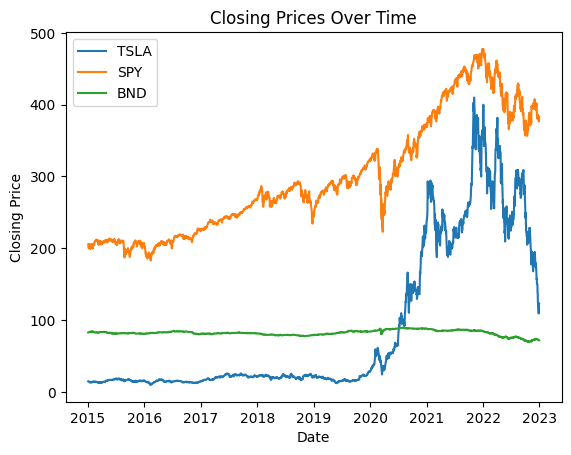

In [34]:
def plot_closing_prices(*dfs, labels):
    for df, label in zip(dfs, labels):
        plt.plot(df.index, df['Close'], label=label)
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.title('Closing Prices Over Time')
    plt.show()

plot_closing_prices(tsla_data, spy_data, bnd_data, labels=['TSLA', 'SPY', 'BND'])


### Train ARIMA/SARIMA Models

In [35]:

def train_arima(data, order, steps=30):
    model = ARIMA(data, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return forecast


ARIMA Model Training for BND, SPY, and TSLA

In [36]:
# BND ARIMA Forecast
forecast_bnd_arima = train_arima(bnd_data['Close'], order=(0,1,0))
mae_bnd_arima, rmse_bnd_arima, mape_bnd_arima = evaluate_forecast(bnd_data['Close'][-30:], forecast_bnd_arima)

# SPY ARIMA Forecast
forecast_spy_arima = train_arima(spy_data['Close'], order=(3,1,1))
mae_spy_arima, rmse_spy_arima, mape_spy_arima = evaluate_forecast(spy_data['Close'][-30:], forecast_spy_arima)

# TSLA ARIMA Forecast
forecast_tsla_arima = train_arima(tsla_data['Close'], order=(0,1,1))
mae_tsla_arima, rmse_tsla_arima, mape_tsla_arima = evaluate_forecast(tsla_data['Close'][-30:], forecast_tsla_arima)


SARIMA Model Training for BND, SPY, and TSLA

In [37]:
def train_sarima(data, order, seasonal_order, steps=30):
    model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return forecast


In [38]:
# BND SARIMA Forecast
forecast_bnd_sarima = train_sarima(bnd_data['Close'], order=(0,1,0), seasonal_order=(2,1,0,5))
mae_bnd_sarima, rmse_bnd_sarima, mape_bnd_sarima = evaluate_forecast(bnd_data['Close'][-30:], forecast_bnd_sarima)

# SPY SARIMA Forecast
forecast_spy_sarima = train_sarima(spy_data['Close'], order=(3,1,1), seasonal_order=(2,1,0,5))
mae_spy_sarima, rmse_spy_sarima, mape_spy_sarima = evaluate_forecast(spy_data['Close'][-30:], forecast_spy_sarima)

# TSLA SARIMA Forecast
forecast_tsla_sarima = train_sarima(tsla_data['Close'], order=(0,1,1), seasonal_order=(0,0,0,0))
mae_tsla_sarima, rmse_tsla_sarima, mape_tsla_sarima = evaluate_forecast(tsla_data['Close'][-30:], forecast_tsla_sarima)


LSTM Model Training for BND, SPY, and TSLA

In [39]:
def prepare_lstm_data(data, time_steps=60):
    scaled_data = (data - data.min()) / (data.max() - data.min())
    generator = TimeseriesGenerator(scaled_data.values, scaled_data.values, length=time_steps, batch_size=32)
    return generator, scaled_data

bnd_gen, bnd_scaled = prepare_lstm_data(bnd_data['Close'])
spy_gen, spy_scaled = prepare_lstm_data(spy_data['Close'])
tsla_gen, tsla_scaled = prepare_lstm_data(tsla_data['Close'])


In [ ]:
def build_and_train_lstm(generator, epochs=10):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(60, 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(generator, epochs=epochs)
    return model

def forecast_with_lstm(model, scaled_data, steps=30):
    predictions = []
    batch = scaled_data[-60:].values.reshape((1, 60, 1))  

    for _ in range(steps):
        pred = model.predict(batch)[0]
        predictions.append(pred)
        batch = np.append(batch[:, 1:, :], [[pred]], axis=1)  

    return np.array(predictions).flatten()


def prepare_lstm_data(data, time_steps=60):

    scaled_data = (data - data.min()) / (data.max() - data.min())
    generator = TimeseriesGenerator(scaled_data.values, scaled_data.values, length=time_steps, batch_size=32)
    return generator, scaled_data


bnd_gen, bnd_scaled = prepare_lstm_data(bnd_data['Close'])
spy_gen, spy_scaled = prepare_lstm_data(spy_data['Close'])
tsla_gen, tsla_scaled = prepare_lstm_data(tsla_data['Close'])


model_bnd_lstm = build_and_train_lstm(bnd_gen, epochs=10)
model_spy_lstm = build_and_train_lstm(spy_gen, epochs=10)
model_tsla_lstm = build_and_train_lstm(tsla_gen, epochs=10)


forecast_bnd_lstm = forecast_with_lstm(model_bnd_lstm, bnd_scaled)
forecast_spy_lstm = forecast_with_lstm(model_spy_lstm, spy_scaled)
forecast_tsla_lstm = forecast_with_lstm(model_tsla_lstm, tsla_scaled)


mae_bnd_lstm, rmse_bnd_lstm, mape_bnd_lstm = evaluate_forecast(bnd_data['Close'][-30:], forecast_bnd_lstm)
mae_spy_lstm, rmse_spy_lstm, mape_spy_lstm = evaluate_forecast(spy_data['Close'][-30:], forecast_spy_lstm)
mae_tsla_lstm, rmse_tsla_lstm, mape_tsla_lstm = evaluate_forecast(tsla_data['Close'][-30:], forecast_tsla_lstm)

print("BND LSTM - MAE:", mae_bnd_lstm, "RMSE:", rmse_bnd_lstm, "MAPE:", mape_bnd_lstm)
print("SPY LSTM - MAE:", mae_spy_lstm, "RMSE:", rmse_spy_lstm, "MAPE:", mape_spy_lstm)
print("TSLA LSTM - MAE:", mae_tsla_lstm, "RMSE:", rmse_tsla_lstm, "MAPE:", mape_tsla_lstm)


Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0777
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0015
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0012
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0012
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 8.5147e-04
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0012
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0013
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0012
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0013
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0012
Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0197
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0024
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 6.5467e-04
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 8.7186e-04
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 6.93

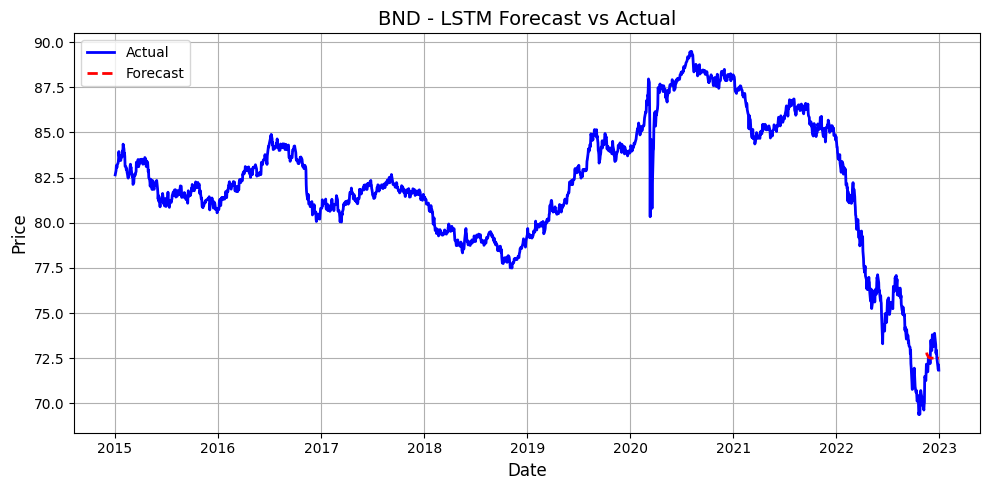

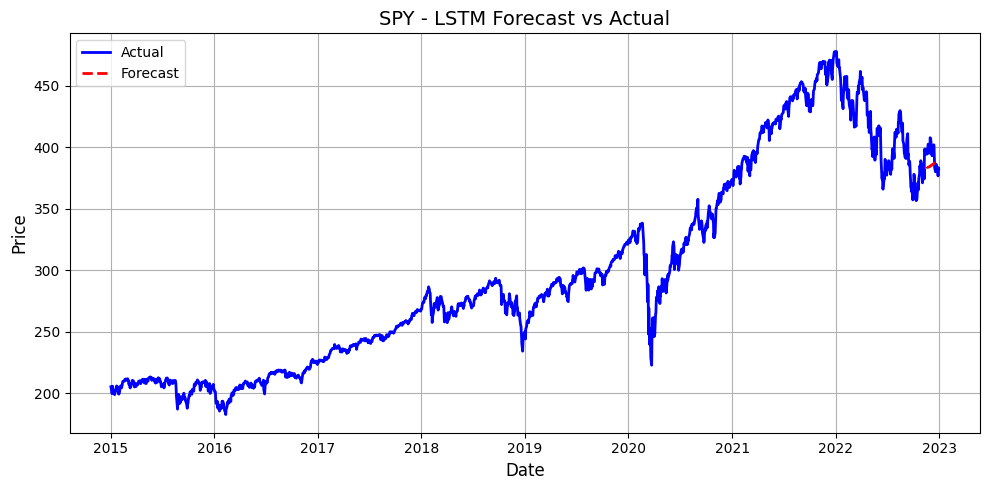

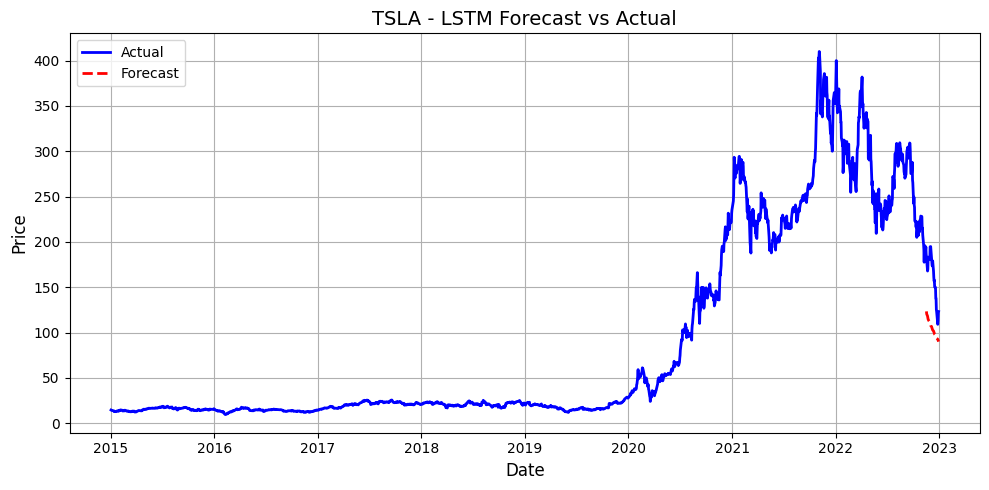

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_forecast(data, forecast, title):
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data['Close'], label='Actual', color='blue', linewidth=2)
    plt.plot(data.index[-len(forecast):], forecast, label='Forecast', color='red', linestyle='--', linewidth=2)
    plt.title(f"{title} - LSTM Forecast vs Actual", fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def invert_scaling(forecast, original_data):
    min_val = original_data.min()
    max_val = original_data.max()
    return forecast * (max_val - min_val) + min_val

forecast_bnd_lstm_inverted = invert_scaling(forecast_bnd_lstm, bnd_data['Close'])
forecast_spy_lstm_inverted = invert_scaling(forecast_spy_lstm, spy_data['Close'])
forecast_tsla_lstm_inverted = invert_scaling(forecast_tsla_lstm, tsla_data['Close'])

plot_forecast(bnd_data, forecast_bnd_lstm_inverted, "BND")
plot_forecast(spy_data, forecast_spy_lstm_inverted, "SPY")
plot_forecast(tsla_data, forecast_tsla_lstm_inverted, "TSLA")


### Task 4

In [44]:
df = pd.DataFrame({
    'TSLA': forecast_tsla_lstm_inverted,
    'BND': forecast_bnd_lstm_inverted,
    'SPY': forecast_spy_lstm_inverted
})

In [45]:
df_returns = df.pct_change().dropna()

In [46]:
annualized_returns = df_returns.mean() * 252  
cov_matrix = df_returns.cov() * 252 

In [47]:

def portfolio_performance(weights):
    portfolio_return = np.sum(weights * annualized_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio

In [48]:
def negative_sharpe_ratio(weights):
    return -portfolio_performance(weights)[2]

In [49]:
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

bounds = tuple((0, 1) for _ in range(len(df.columns)))

initial_weights = np.array([1/3, 1/3, 1/3])

In [51]:
from scipy.optimize import minimize
optimized_result = minimize(negative_sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = optimized_result.x